In [68]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# load the dataset
df = pd.read_csv('M_metadata_v1.csv')
rs = 40
df.info()
#df

print("----------------------------------------------")
print(df._get_value(index=0, col='Description')[:200])
print("\nAverage length of Description column:")
print(df['Description'].apply(lambda x: len(x)).mean())

print("\nnumber of occurences for each unique value in product_name")
print("-----------------------------------------------------------------")
print(df['Genre'].value_counts())
#print(df['Studio'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Cast 1        799 non-null    object
 1   Cast 2        799 non-null    object
 2   Cast 3        799 non-null    object
 3   Cast 4        799 non-null    object
 4   Cast 5        799 non-null    object
 5   Cast 6        799 non-null    object
 6   Description   799 non-null    object
 7   Director 1    799 non-null    object
 8   Director 2    799 non-null    object
 9   Director 3    799 non-null    object
 10  Genre         799 non-null    object
 11  Rating        799 non-null    object
 12  Release Date  799 non-null    object
 13  Runtime       799 non-null    object
 14  Studio        799 non-null    object
 15  Title         799 non-null    object
 16  Writer 1      799 non-null    object
 17  Writer 2      799 non-null    object
 18  Writer 3      799 non-null    object
 19  Writer 4

In [38]:
import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# load the dataset
data = pd.read_csv('M_metadata_v1.csv')

# initialise wordnet lemmatizer and punctuation filter
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)

# join provided stopwords with the default NLTK English stopwords
stopwords = set(sw.words('english'))

# Function to lemmatize tokens
# token = represents the word to lemmatize
# tag = represents the part-of-speech tag of the word
def lemmatize(token, tag): # takes two parameters
# mapping POS tags to wordnet pos categories
#(lexical database, associates words with their meanings)
# and categorizes words based on their part of speech
    tag = { 
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

# document refers to the text data ('Description') we want to preprocess 
# each 'description' is considered a document
def preprocess_tokenizer(document): 
    tokens = [] # initalize token list
    
    for sent in sent_tokenize(document):
        # Split the document into tokens and create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            # if stopword (the, and, is), ignore token and continue
            # removed, since they don´t carry significant meaning and can add noise to the analysis.
            # helps focus on the more informative words
            if token in stopwords:
                continue
            # if punctuation, ignore token and continue
            # don´t provide meaningful information for text analysis
            # including them can introduce noise, helps clean the text data
            if all(char in punct for char in token):
                continue
            # Lemmatize the token and add back to the tokens list
            lemma = lemmatize(token, tag)
            tokens.append(lemma) # resulting lemmatized word is added to the list tokens
    return tokens # returns the list of lemmatized word, after all tokens in the text have been processed

# apply the preprocessing to the "Description" column
data['Description'] = data['Description'].apply(preprocess_tokenizer)

# Text preprocessing - bag of words (each individual documents is split into tokens - tokenisation)
# Tokenizer (Lowercase, Punctuation("," ".", part of speech and lemmatisation)
# Stop Word filtering (a, an, and, the, is)

In [39]:
# transform the tokens into matrices
from sklearn.feature_extraction.text import TfidfVectorizer
# tf idf vectoriser
tfidf_vec = TfidfVectorizer(tokenizer=preprocess_tokenizer, ngram_range=(1,2))
X = tfidf_vec.fit_transform(df['Description'])
# see the number of unique tokens produced by the vectorizer. Lots of them...

print("Transforming text data into document frequency - matrices:")
print(len(tfidf_vec.get_feature_names_out()))
print("\nThe output indicates that the text data 'Description', contains a large number of unique terms of words")


Transforming text data into document frequency - matrices:
65478

The output indicates that the text data 'Description', contains a large number of unique terms of words


# DATA PREPROCESSING
- The dataset contains 799 entries
- I will focus on the Description column, which is the text data, and I will like to analyze this one. 

Text Cleaning:
Remove any special characters, punctuation, and numbers from the text.
Convert the text to lowercase for consistency.

Tokenization:
Tokenize the text, breaking it down into individual words or tokens. This will allow you to work with the words in the 
text.

Stop Word Removal (we need to discuss this, can be optional, since if we remove, then we might lossing important information):
Depending on your analysis, you can remove common stop words (e.g., "the," "and," "is") from the text, which are not informative for clustering.

In [34]:
# Perform text analysis on this dataset to determine clusters of movies
#based on similar topics that can be obtained from the movie descriptions

from sklearn.cluster import KMeans
# K means clustering using the term vector
# creating 10 clusters of movies
# X (matrix) represents the movies descriptions after preprocessing, tokenization
kmeans = KMeans(n_clusters=10, random_state=rs).fit(X) 

# function to visualise text cluster - visualise the top terms (words)
# associated with each cluster after K-Means clustering
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 5):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/
    # other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :5]:
            print(terms[term_idx], end=', ')
        print()
        
# call it
visualise_text_cluster(kmeans.n_clusters, kmeans.cluster_centers_, 
                       tfidf_vec.get_feature_names_out())


Top terms for cluster 0: kelly, charisse, camille, haunt, dexter, 
Top terms for cluster 1: david, find, life, world, rachel, 
Top terms for cluster 2: city, human, bella, life, work, 
Top terms for cluster 3: film, life, documentary, voice, one, 
Top terms for cluster 4: harry, prince, game, power, adventure, 
Top terms for cluster 5: century, queen, elizabeth, orlando, story, 
Top terms for cluster 6: family, earth, day, save, space, 
Top terms for cluster 7: c official, official, official site, c, site, 
Top terms for cluster 8: peter, child, charlie, kid, jack, 
Top terms for cluster 9: love, film, life, woman, one, 


# Interpretion of the above K-means output

The output shows the top terms (words) associated with each of the clusters generated by K-Means clustering. The "Top terms for cluster X" lines represent the cluster number, followed by the top terms in that cluster. 

1. **Cluster 0**: This cluster is associated with terms like "kelly," "charisse," "camille," "haunt," and "dexter." These terms suggest that movies in this cluster may be related to characters or stories involving individuals with names like Kelly, Charisse, and Camille, and possibly feature elements of haunting or mystery (e.g., "haunt" and "dexter").

2. **Cluster 1**: Terms associated with this cluster include "david," "find," "life," "world," and "rachel." This cluster may contain movies that revolve around themes related to characters named David, life exploration, and possibly journeys to discover or find something in the world (e.g., "world" and "find").

3. **Cluster 2**: This cluster includes terms such as "city," "human," "bella," "life," and "work." It suggests that movies in this cluster may deal with urban settings ("city"), human experiences ("human"), the life of a character named Bella, and possibly work-related themes.

4. **Cluster 3**: Terms associated with this cluster include "film," "life," "documentary," "voice," and "one." This cluster may be related to movies about filmmaking, documentaries, and the representation of life and voices.

5. **Cluster 4**: This cluster includes terms like "harry," "prince," "game," "power," and "adventure." It suggests that movies in this cluster may involve royal or princely characters (e.g., "harry" and "prince"), games, power struggles, and adventurous stories. Movie related to royalty and adventure theme

6. **Cluster 5**: Terms associated with this cluster include "century," "queen," "elizabeth," "orlando," and "story." This cluster may contain historical or period pieces set in different centuries, potentially featuring Queen Elizabeth. NOTE: Not shure why "orlando" is there, what is the connection? look more into this

7. **Cluster 6**: This cluster includes terms such as "family," "earth," "day," "save," and "space." It suggests that movies in this cluster may revolve around family dynamics, Earth-related themes, saving or protecting something, and possibly space exploration. Could be related to genre kids&family

8. **Cluster 7**: This cluster appears to contain terms related to website URLs ("official," "official site," "site"). This could indicate that these movies are associated with official websites or online content.

9. **Cluster 8**: Terms associated with this cluster include "peter," "child," "charlie," "kid," and "jack." It suggests that movies in this cluster may feature characters named Peter, Charlie, and Jack, and may have child or kid-related themes. NOTE: "child", "kid", duplicates? same meaning different terms, look more into this.

10. **Cluster 9**: This cluster includes terms like "love," "film," "life," "woman," and "one." It indicates that movies in this cluster may focus on themes related to love, life experiences, and the stories of women.

Each cluster represents a group of movies that share similar themes or topics based on the words found in their descriptions. The top terms provide insights into the content and subject matter of movies within each cluster.

However,

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# creating tf-idf terms - a bit slow, do it occasionaly
def calculate_tf_idf_terms(document_col):
    # Param - document_col:
    # collection of raw document text that you want to analyse
    from sklearn.feature_extraction.text import CountVectorizer
    
    # use count vectorizer to find TF and DF of each term
    count_vec = CountVectorizer(tokenizer=preprocess_tokenizer, ngram_range=(1,2))
    X_count = count_vec.fit_transform(df['Description'])
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
            for t in count_vec.vocabulary_]
    return terms
terms = calculate_tf_idf_terms(df['Description'])


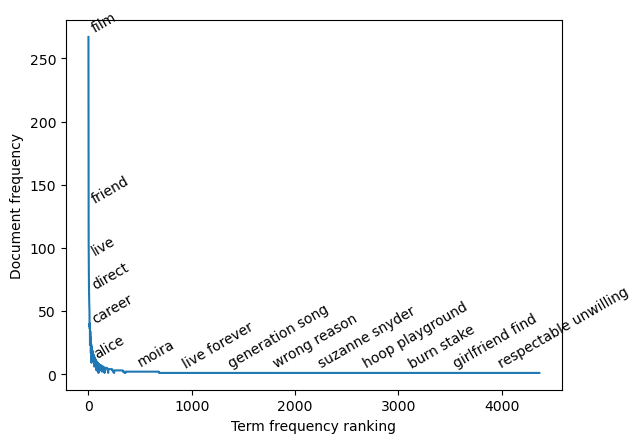

In [65]:
# Visualization / interpretation of ZIPF law
def visualise_zipf(terms, itr_step = 15):
    from scipy.spatial.distance import euclidean
    from math import sqrt
    
    # --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot.
    # Num of terms to plot = N terms / itr_step
    
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
                                                                                 
                                                                                 
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)),
                            [x['df'] for x in sel_terms]):
        
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)

        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'},
                     rotation=30)
            prev_x, prev_y = x, y

    plt.show()
visualise_zipf(terms)

# most frequently genre or movies (title)

In [53]:
# another tf idf vectoriser
# limit the terms produced to terms that occured in min of 2 documents
# and max 80% of all documents
filter_vec = TfidfVectorizer(tokenizer=preprocess_tokenizer, ngram_range=(1,2),
                             min_df=2, max_df=0.8)

X_filter = filter_vec.fit_transform(df['Description'])

# see the number of unique tokens produced by the vectorizer.
# it has been reduced, seen out of the result
print("Number of unique tokens produced by the vectorizer")
print(len(filter_vec.get_feature_names_out()))

Number of unique tokens produced by the vectorizer
9924


In [56]:
%%time
# K means clustering using the new term vector, time it for comparison to SVD
kmeans_fil = KMeans(n_clusters=10, random_state=rs).fit(X_filter)

CPU times: user 1.27 s, sys: 74.8 ms, total: 1.34 s
Wall time: 695 ms


In [62]:
# visualisation
visualise_text_cluster(kmeans_fil.n_clusters, kmeans_fil.cluster_centers_,
filter_vec.get_feature_names_out())

Top terms for cluster 0: film, love, year, alice, follow, 
Top terms for cluster 1: find, life, paul, become, way, 
Top terms for cluster 2: story, c, official, film, c official, 
Top terms for cluster 3: film, world, adventure, must, young, 
Top terms for cluster 4: life, best, film, one, love, 
Top terms for cluster 5: new, story, life, woman, love, 
Top terms for cluster 6: christmas, santa, holiday, claus, santa claus, 
Top terms for cluster 7: family, team, comedy, take, adventure, 
Top terms for cluster 8: century, queen, orlando, colony, earth, 
Top terms for cluster 9: life, get, bob, mother, rovi, 


# Interpretion on result after using TF-IDF vectorizer with term filtering

The terms above or output represent the top words associated with each cluster. It appears that the clustering has grouped movies based on some common themes or topics, as suggested by the terms within each cluster. This information can be valuable for organizing and recommending movies to customers based on similar content and themes.

    cluster 0: Romance
    cluster 2: Documentary
    cluster 6: Kids&Family
    cluster 8: Sci-Fi

The use of TF-IDF with term filtering (min_df and max_df) has helped reduce the number of unique tokens while preserving the most relevant terms for clustering. This can make the clustering results more meaningful and interpretable.

Top terms for cluster 2: story, c, official, film, c official, NOTE: something fishy here, what is the difference with c and c official. I notice that there is a comma here: c, official (maybe it supposed to be c official) Look more into this, something wrong somewhere. The same with this cluster: Top terms for cluster 6: christmas, santa, holiday, claus, santa claus, 


# Assessment task 3: Text Analysis

Description is an important column to consider, this will help us to find what movies are most popular and genre

1) **What variables did you include in the analysis and what were their roles and measurement level set? Justify your choice.**

**Description:** This variable plays the central role in the analysis. It contains textual descriptions of movies, and its measurement level is "Text" or "Nominal" because it consists of unstructured text data. The objective is to cluster movies based on the textual content in these descriptions.

**Genre:** This variable is essential for considering movie genres when forming clusters. It has a measurement level of "Categorical" because it consists of predefined categories, such as "Documentary," "SciFi," "Romance," and "Kids&Family." The role of this variable is to provide additional context for the clustering process, allowing for clusters of movies with similar genres and themes.

2) **Based on the ZIPF plot, list the top 10 terms that will be least useful for clustering purpose.**
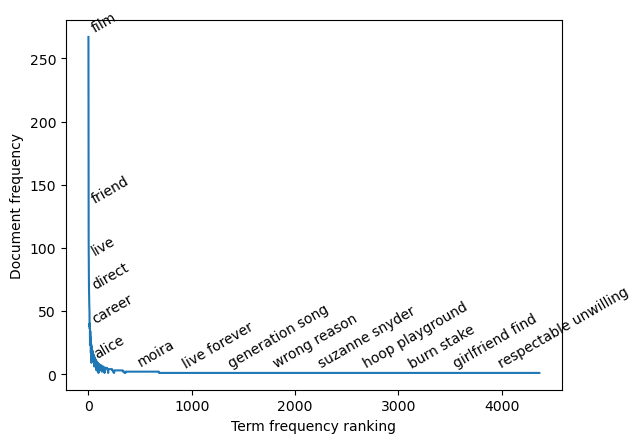

3) **Did you disregard any frequent terms? Justify your answer**


4) **Justify the term weighting option selected, and what is the number of input features available to execute k-means clustering? (Please note that how the original text data is converted into a feature set to support text analysis**

The term weighting option selected is TF-IDF, it was used because TF-IDF accounts for the variability in document lengths, ensuring that longer documents don't have an unfair advantage in clustering. This normalization is essential in text analysis, where documents can vary significantly in length. And it weighs terms based on their importance in a document relative to their frequency in the entire corpus. This means that terms that are frequent in a document but rare in the corpus are given higher importance. This is crucial for identifying distinctive terms and themes.But also, it helps highlight the distinctiveness of terms in documents, making it a suitable choice for text analysis and the purpose of this task. 

the number of input features available to execute k-means clustering is determined by the dimensionality of the TF-IDF representation of the text data. In this case, the TF-IDF vectorizer is used to convert the original text data into a feature set. Each feature represents a unique term in the text corpus. The dimensionality is equal to the total number of unique terms or words across all the documents in the corpus. 

After applying the TF-IDF vectorizer with term filtering (min_df and max_df), the number of unique tokens produced has been reduced. This reduction in dimensionality simplifies the clustering process and makes it more manageable.

5) **Find the optimal k. Plot and explain your answer.**

One way to determine the optimal k is by using the "elbow method." The elbow method involves running K-Means with a range of k values and plotting the sum of squared distances (inertia) for each k. The point at which the inertia starts to show diminishing returns or forms an "elbow" in the plot is considered the optimal k.
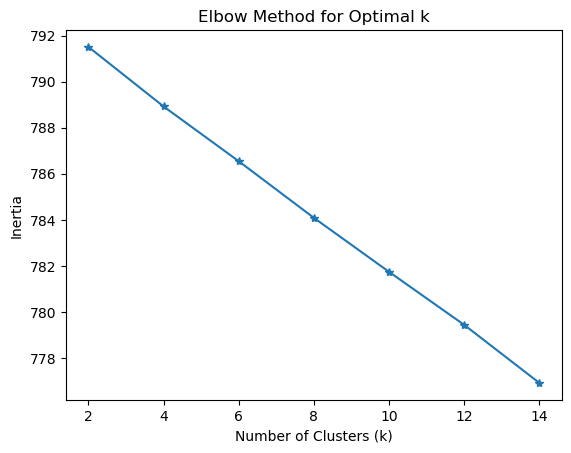
Need to check this, can not find a clear elbow. Maybe because the data doesn´t have a clear clustering structure, or maybe there might be multiple valid values for k


6) **How many clusters are generated? Provide a way to meaningfully name each cluster and then display the results**



7) **How the outcome of your analysis can be used by the decision maker? Given an application or an example where this outcome can be used by the cinema**

MOVIE RECOMMENDATION APPLICATION / SYSTEM
- Uses the clustering results to suggest movies to cinema customers

**Personalized Movie Recommendations:** When a user visits the cinema's website or app, the system can analyze their past movie preferences, ratings, or browsing history.

**Identify User Preferences:** Based on the user's profile, the system can determine which cluster of movies aligns with the user's preferences. For example, if the user has previously enjoyed sci-fi and adventure films, they might be assigned to the "Sci-Fi Adventures" cluster.

**Recommend Movies:** The recommendation system can suggest movies from the cluster that matches the user's preferences. For our example, it might recommend the latest sci-fi adventure movie that's currently playing at the cinema.

**Diverse Recommendations:** To ensure diversity, the system can also recommend movies from clusters that are closely related to the user's primary cluster. For instance, if the user loves sci-fi adventures, they might also enjoy action and thriller movies. So, the system can provide recommendations from both clusters.

**This can be a benefit to both the Cinema and users**

**Improved User Experience:** Users receive movie recommendations that align with their tastes, leading to a more enjoyable cinema experience.

**Increased Ticket Sales:** By matching users with movies they're likely to enjoy, the cinema can increase ticket sales.

**Optimized Inventory Management:** Cinemas can optimize their movie showtimes and schedules based on the popularity of each cluster. For instance, if "Romantic Dramas" are trending, they can allocate more screening slots for such movies.

**Marketing and Promotion:** Cinemas can use the clustering data to target marketing campaigns and promotions more effectively. They can promote specific clusters to users who have shown an interest in those genres.

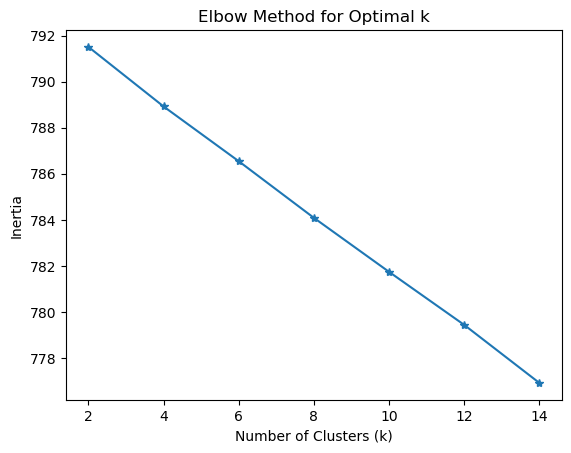

In [76]:
#list to save the clusters and cost
clusters = []
inertia_vals = []

# this whole process should take a while
for k in range(2, 15, 2):
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)
    
# plot the inertia vs K values
plt.plot(range(2,15,2), inertia_vals, marker='*')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

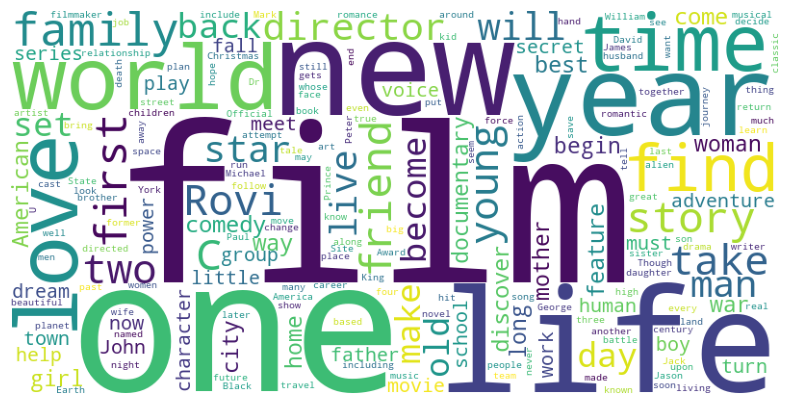

In [86]:
# Not needed, was just testing something
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

# Combine movie descriptions into a single text
movie_descriptions = " ".join(df['Description'])  

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS, collocations=False).generate(movie_descriptions)

# Set the figure size
plt.figure(figsize=(10, 5))

# Display the word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# https://www.analyticsvidhya.com/blog/2021/05/how-to-build-word-cloud-in-python/